---

# Teleporte Quântico

O **teleporte quântico** permite transferir o **estado quântico desconhecido**  
de um qubit de **Alice** (emissora) para um qubit de **Bob** (receptor) **sem mover fisicamente o qubit**.  
O protocolo usa dois recursos fundamentais:

1. **Emaranhamento** pré-compartilhado (um par EPR).  
2. Um **canal clássico** para dois bits de informação.

> ⚠️ Nenhuma informação viaja mais rápido que a luz: Bob só recria o estado **depois** de receber os bits clássicos de Alice.

---

## Ilustração clássica (analogia)

1. Alice e Bob estão juntos num parque.  
2. Eles jogam cara-ou-coroa duas vezes e escrevem os resultados numa folha dividida ao meio, destruindo o verso da outra metade — criando duas metades que “encaixam” (analogia ao entrelaçamento).  
3. Cada um leva sua metade e parte para lugares distantes.  
4. Mais tarde, Alice quer mandar uma mensagem “secreta” (estado $\ket{\psi}$).  
5. Ela faz uma operação na sua metade (medição) e envia **dois bits clássicos** a Bob.  
6. Bob, com esses bits, faz um ajuste na própria metade, que passa a conter exatamente a mensagem de Alice.  

---

## Protocolo de Teleporte (versão quântica)

1. **Preparação do par EPR**  
   Alice e Bob criam juntos o estado Bell  
   $$\ket{\Phi^{+}} = \tfrac{1}{\sqrt2}(\ket{00}+\ket{11})$$  
   e se separam levando, respectivamente, os qubits $A_2$ e $B$.

2. **Objetivo**  
   Alice possui um terceiro qubit $A_1$ no estado **desconhecido**  
   $$\ket{\psi}=\alpha\ket{0}+\beta\ket{1}.$$

3. **Operações locais de Alice**  
   - Aplica **CNOT** entre $A_1$ (controle) e $A_2$ (alvo).  
   - Aplica **Hadamard** em $A_1$.  
   - Mede $A_1A_2$ na base computacional, obtendo dois bits $m\_1m\_2$.

4. **Canal clássico**  
   Alice envia $(m_1,m_2)$ a Bob por um canal comum (e-mail, luz, rádio…).

5. **Correção de Bob**  
   Bob aplica uma porta unitária condicional em seu qubit $B$:  

   | $m_1m_2$ | Porta em $B$ |
   |----------|--------------|
   | 00       | $\;I$        |
   | 01       | $X$          |
   | 10       | $Z$          |
   | 11       | $ZX$         |

6. **Resultado**  
   O qubit de Bob torna-se exatamente $\ket{\psi}$,  
   enquanto o qubit original de Alice perde essa informação (colapso).

---

Depois desta explicação teórica, nas próximas células:

- Construiremos o circuito de teleporte passo a passo no Qiskit.  
- Simularemos cada etapa para conferir as probabilidades.  
- Finalmente executaremos o protocolo em um backend real da IBM Quantum e analisaremos as imperfeições introduzidas pelo ruído.

---

> Neste notebook, o estado desconhecido $|\psi\rangle$ é gerado a partir de
> parâmetros aleatórios $\theta$ e $\varphi$ com a porta  
> $\mathrm U(\theta,\varphi,0)$.  
> As medições são gravadas como: `cr[0] = m_2` (resultado de \*secret\*)  
> e `cr[1] = m_1` (resultado de \*Alice\*). As correções condicionais
> em Bob usam a nova sintaxe `if_test` do Qiskit v0.46.

---

---

## Verificação ativa do teleporte  

Para comprovar experimentalmente que o estado $\ket{\psi}$ **realmente chegou a Bob**, acrescentamos uma etapa de **verificação ativa**:

1. Depois que Bob aplica a correção condicional $I$, $X$, $Z$ ou $ZX$,  
   ele possui (idealmente) o qubit no estado **exato** $\ket{\psi}$.

2. Aplicamos em Bob a **porta inversa**  
   $$ U^\dagger(\theta,\varphi,0) = U(-\theta, -\varphi, 0), $$
   isto é, a porta que desfaz a preparação aleatória executada por Alice  
   ($\theta$, $\varphi$ são os mesmos parâmetros da $U$ original).

3. Se o teleporte foi perfeito, o qubit de Bob volta para $\ket{0}$.  
   Em seguida, medimos Bob em um terceiro bit clássico `cr[2]`.

### O que esperamos nos resultados

| Bits (m₂ m₁) | Correção em Bob | Estado **antes** de $U^\dagger$ | Estado **após** $U^\dagger$ | Bit de Bob |
|--------------|------------------|----------------------------------|------------------------------|-------------|
| 00           | $I$              | $\ket{\psi}$                     | $\ket{0}$                    | `0`         |
| 01           | $X$              | $X\ket{\psi}$                    | $X\ket{0} = \ket{1}$         | `0`         |
| 10           | $Z$              | $Z\ket{\psi}$                    | $Z\ket{0} = \ket{0}$         | `0`         |
| 11           | $ZX$             | $ZX\ket{\psi}$                   | $ZX\ket{0} = \ket{1}$        | `0`         |

- **Em teoria**, o terceiro bit clássico (Bob) deve ser **sempre `0`**.  
- Populações não nulas em `…1` fornecem uma **estimativa direta da taxa de erro** do protocolo, pois indicam que Bob não recebeu o estado correto ou que a inversão $U^\dagger$ não devolveu $\ket{0}$.

Na prática, ao rodar em um **simulador com o NoiseModel do backend**, veremos pequenas barras para as chaves cujo último dígito é `1`.  
No **hardware real**, essas barras podem aumentar, refletindo erros de porta, decoerência e imprecisão de leitura.

---

**Próximas células**

1. Implementaremos o circuito completo com a verificação $U^\dagger$.  
2. Executaremos:

   - no **simulador ideal** (probabilidade de Bob=`0` = 1),  
   - no **simulador com ruído do backend** (Bob=`1` aparece raramente),  
   - e finalmente no **backend físico**, analisando a fidelidade prática.

---


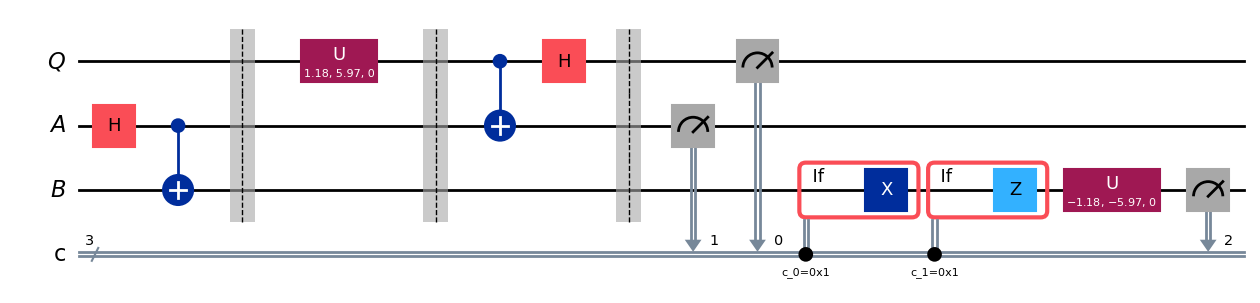

In [ ]:
# -------------------------------------------------------------
# Circuito de Teleporte em Qiskit — com verificação em Bob
# -------------------------------------------------------------
# • Prepara estado aleatório |ψ⟩ em `secret`
# • Teleporta para `bob`
# • Bob aplica U†(θ,φ)  →  se o teleporte estiver correto,
#   o qubit deve colapsar em |0⟩ quando for medido.
# -------------------------------------------------------------

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np
from numpy import pi

# ---------- Registros ----------
secret = QuantumRegister(1, "Q")   # qubit com |ψ⟩
alice  = QuantumRegister(1, "A")   # qubit de Alice
bob    = QuantumRegister(1, "B")   # qubit de Bob
cr     = ClassicalRegister(3, "c") # c0=m2, c1=m1, c2=Bob

qc = QuantumCircuit(secret, alice, bob, cr)

# ---------- (1) Par EPR entre Alice e Bob ----------
qc.h(alice)
qc.cx(alice, bob)
qc.barrier()

# ---------- (2) Prepara estado aleatório |ψ⟩ em `secret` ----------
np.random.seed(42)
theta = np.random.uniform(0, 1) * pi
phi   = np.random.uniform(0, 2) * pi
qc.u(theta, phi, 0.0, secret)          # |ψ⟩ = U(θ,φ,0)|0⟩
qc.barrier()

# ---------- (3) Operações de Alice ----------
qc.cx(secret, alice)
qc.h(secret)
qc.barrier()

# ---------- (4) Medições de Alice ----------
qc.measure(alice,  cr[1])   # m1
qc.measure(secret, cr[0])   # m2

# ---------- (5) Correções condicionais em Bob ----------
with qc.if_test((cr[0], 1)):  # se m2 == 1 → X
    qc.x(bob)
with qc.if_test((cr[1], 1)):  # se m1 == 1 → Z
    qc.z(bob)

# ---------- (6) Verificação: aplica U†(θ,φ) em Bob e mede ----------
qc.u(-theta, -phi, 0.0, bob)  # U†; devolve |ψ⟩ a |0⟩ se teleporte correto
qc.measure(bob, cr[2])        # Bob deve ler 0 (idealmente)

# ---------- Desenha o circuito ----------
qc.draw(output="mpl")


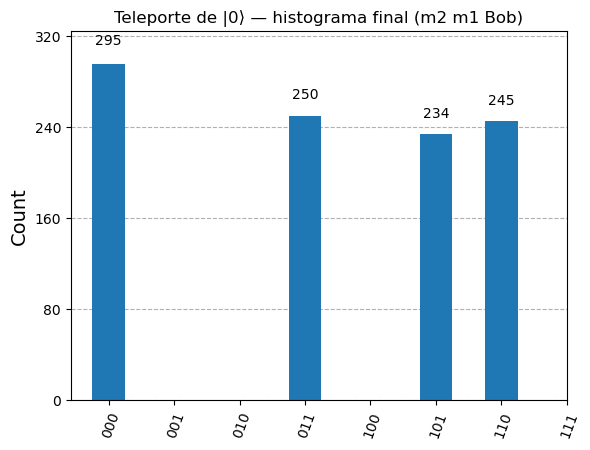

In [33]:
# -------------------------------------------------------------
# Histograma final do protocolo de teleporte (estado |0⟩)
# -------------------------------------------------------------
# Após as medições e correções, o qubit de Bob deve estar em |0⟩
# As chaves representadas são de 3 bits: m2 (c0), m1 (c1), Bob (c2)
# Espera-se: chaves terminando em 0 (…0) com ~25% cada.
# -------------------------------------------------------------

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from IPython.display import display

# --- Simulador ideal ---
sim = AerSimulator()
shots = 1024

# --- Registros ---
qS = QuantumRegister(1, "Q")   # qubit secreto (|0⟩)
qA = QuantumRegister(1, "A")   # Alice
qB = QuantumRegister(1, "B")   # Bob
cr  = ClassicalRegister(3, "c")  # c0=m2, c1=m1, c2=Bob

# --- Circuito ---
qc = QuantumCircuit(qS, qA, qB, cr)

# Par EPR entre qA e qB
qc.h(qA)
qc.cx(qA, qB)

# Interação qubit secreto com Alice
qc.cx(qS, qA)
qc.h(qS)

# Medições de Alice
qc.measure(qA, cr[1])   # m1
qc.measure(qS, cr[0])   # m2

# Correções condicionais em Bob
with qc.if_test((cr[0], 1)):   # m2 == 1
    qc.x(qB)
with qc.if_test((cr[1], 1)):   # m1 == 1
    qc.z(qB)

# Medição de Bob (deve dar |0⟩)
qc.measure(qB, cr[2])

# --- Simulação ---
job = sim.run(transpile(qc, sim), shots=shots)
counts = job.result().get_counts()

# --- Reorganiza os bits para (m2 m1 Bob) ---
# As chaves vêm como "c2c1c0", queremos reordenar para "c0c1c2"
counts_fmt = {}
for bits, freq in counts.items():
    # bits: "Bob m1 m2" → reverter ordem para "m2 m1 Bob"
    reordered = bits[::-1]
    counts_fmt[reordered] = freq

# --- Garante que TODAS as 8 chaves estejam presentes ---
todas_chaves = [f"{i:03b}" for i in range(8)]
for key in todas_chaves:
    counts_fmt.setdefault(key, 0)

# --- Histograma ---
display(plot_histogram(
    counts_fmt,
    title="Teleporte de |0⟩ — histograma final (m2 m1 Bob)",
    sort='asc'
))


In [ ]:
# ------------------------------------------------------------------
# PASSO 0 — Medição do estado |00⟩ no hardware real da IBM Quantum
# ------------------------------------------------------------------
# Bibliotecas e serviço
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from IPython.display import display

# 1) Conecta-se à sua conta (token já salvo previamente)
service = QiskitRuntimeService()



# 2) Escolhe o backend real menos ocupado com ≥127 qubits
backend = service.least_busy(operational=True,
                             simulator=False,
                             min_num_qubits=127)
print("Backend escolhido:", backend.name)

Backend escolhido: ibm_brisbane


Backend selecionado: ibm_brisbane


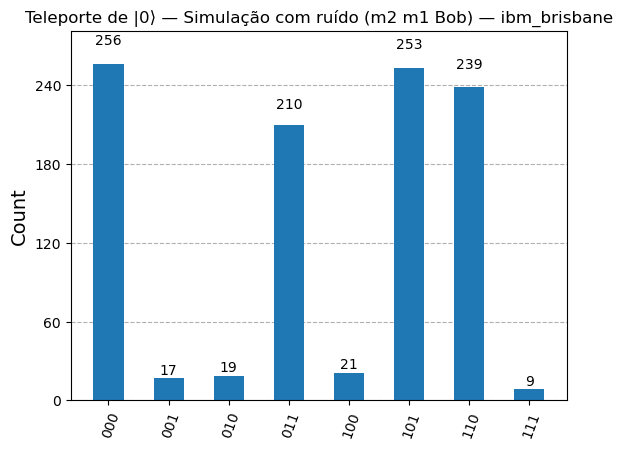

In [34]:
# -------------------------------------------------------------
# Teleporte de |0⟩ — Simulação com ruído do backend real
# -------------------------------------------------------------
# Neste cenário, o qubit "secret" começa em |0⟩.
# Após medições de Alice e correções em Bob,
# o terceiro bit (Bob) deve ser idealmente 0.
# A simulação usa o modelo de ruído extraído do backend escolhido.
# -------------------------------------------------------------

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.visualization import plot_histogram
from IPython.display import display

# 1) Conecta à conta e seleciona um backend real
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
print("Backend selecionado:", backend.name)

# 2) Cria o modelo de ruído com base nesse backend
noise_model = NoiseModel.from_backend(backend)
backend_sim = AerSimulator(noise_model=noise_model)

# 3) Constrói o circuito de teleporte (estado |0⟩)
qS = QuantumRegister(1, "Q")   # qubit secreto (|0⟩)
qA = QuantumRegister(1, "A")   # Alice
qB = QuantumRegister(1, "B")   # Bob
cr  = ClassicalRegister(3, "c")  # c0=m2, c1=m1, c2=Bob

qc = QuantumCircuit(qS, qA, qB, cr)

# Par EPR entre Alice e Bob
qc.h(qA)
qc.cx(qA, qB)

# Operações de Alice
qc.cx(qS, qA)
qc.h(qS)

# Medições de Alice
qc.measure(qA, cr[1])   # m1
qc.measure(qS, cr[0])   # m2

# Correções condicionais em Bob
with qc.if_test((cr[0], 1)):
    qc.x(qB)
with qc.if_test((cr[1], 1)):
    qc.z(qB)

# Medição de Bob
qc.measure(qB, cr[2])

# 4) Transpila para a topologia do simulador com ruído
qc_t = transpile(qc, backend_sim, optimization_level=1)

# 5) Executa a simulação
job = backend_sim.run(qc_t, shots=1024)
counts_raw = job.result().get_counts()

# 6) Reorganiza as chaves para o formato (m2 m1 Bob)
counts_fmt = {}
for key, val in counts_raw.items():
    # bits vêm como 'c2c1c0' → reordenar para 'c0c1c2'
    reordered = key[::-1]
    counts_fmt[reordered] = val

# Garante presença de todas as 8 combinações (com 0 se não apareceram)
todas_chaves = [f"{i:03b}" for i in range(8)]
for key in todas_chaves:
    counts_fmt.setdefault(key, 0)

# 7) Plota o histograma final
display(plot_histogram(
    counts_fmt,
    title=f"Teleporte de |0⟩ — Simulação com ruído (m2 m1 Bob) — {backend.name}",
    sort='asc'
))


Backend real selecionado: ibm_brisbane


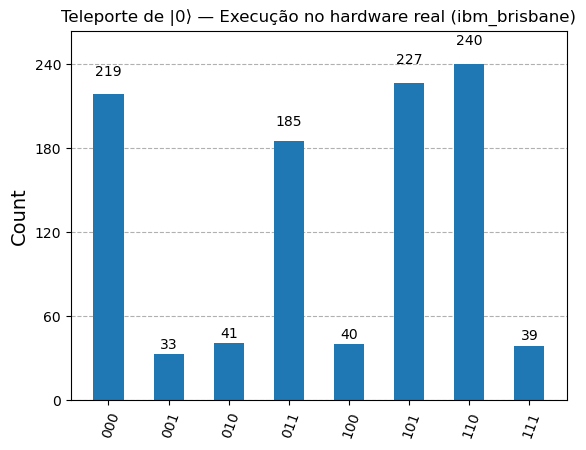

In [35]:
# -------------------------------------------------------------
# Teleporte de |0⟩ — Execução no hardware real da IBM Quantum
# -------------------------------------------------------------
# Cenário: o qubit "secret" está inicialmente em |0⟩.
# Após medições e correções, Bob deve medir |0⟩ com alta fidelidade.
# Esse código envia o circuito para um backend real da IBM.
# -------------------------------------------------------------

from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import BackendSamplerV2
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from IPython.display import display

# 1) Conecta à conta e seleciona um backend real com no mínimo 127 qubits
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
print("Backend real selecionado:", backend.name)

# 2) Define o circuito de teleporte de |0⟩
qS = QuantumRegister(1, "Q")   # qubit secreto (|0⟩)
qA = QuantumRegister(1, "A")   # Alice
qB = QuantumRegister(1, "B")   # Bob
cr  = ClassicalRegister(3, "c")  # c0=m2, c1=m1, c2=Bob

qc = QuantumCircuit(qS, qA, qB, cr)

# Par EPR entre Alice e Bob
qc.h(qA)
qc.cx(qA, qB)

# Interações de Alice com o estado secreto
qc.cx(qS, qA)
qc.h(qS)

# Medições de Alice
qc.measure(qA, cr[1])  # m1
qc.measure(qS, cr[0])  # m2

# Correções em Bob
with qc.if_test((cr[0], 1)):
    qc.x(qB)
with qc.if_test((cr[1], 1)):
    qc.z(qB)

# Verificação: Bob deve medir |0⟩
qc.measure(qB, cr[2])

# 3) Transpila com o preset pass manager para o backend real
target = backend.target
pass_manager = generate_preset_pass_manager(target=target, optimization_level=1)
qc_isa = pass_manager.run(qc)

# 4) Executa com o Sampler real
sampler = Sampler(mode=backend)
job = sampler.run([qc_isa], shots=1024)
result = job.result()
counts_raw = result[0].data.c.get_counts()

# 5) Reorganiza as chaves para o formato lógico (m2 m1 Bob)
counts_fmt = {}
for key, val in counts_raw.items():
    reordered = key[::-1]
    counts_fmt[reordered] = val

# Garante que todas as 8 chaves estejam presentes
todas_chaves = [f"{i:03b}" for i in range(8)]
for chave in todas_chaves:
    counts_fmt.setdefault(chave, 0)

# 6) Exibe histograma final
display(plot_histogram(
    counts_fmt,
    title=f"Teleporte de |0⟩ — Execução no hardware real ({backend.name})",
    sort='asc'
))
